## 1. Setup

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import skimage
import warnings

from dataset_utils import *
from preprocessing import merge_patches
from vis_utils import grid_vis_for_crop_and_merge

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

warnings.filterwarnings('ignore')

In [3]:
ICOSEG_SUBSET_80_PATH = '../datasets/icoseg/subset_80'

## 2. Load patches and merge (for 1 image)

In [4]:
def load_patches(img_name, patches_path):
    patches_names_all = os.listdir(patches_path)
    patches = []
    max_row = 0
    
    for patch_name in sorted(patches_names_all):
        if patch_name.startswith(img_name):
            patch = skimage.io.imread(f'{patches_path}/{patch_name}')
            patches.append(patch)
            
            # useful for patches.reshape
            patch_shape = patch.shape
            row = 1 + int(patch_name.split('_')[-2])
            max_row = max(max_row, row)
            
    patches = np.array(patches).astype(np.uint8).reshape(max_row, -1, *patch_shape)
    
    return patches

real img_h, img_w: 334, 500
img_patches
(2, 2, 256, 256, 3) uint8 0 255 

mask_patches
(2, 2, 256, 256) uint8 0 255 

img_from_patches
(334, 500, 3) uint8 0 255
mask_from_patches
(334, 500) uint8 0 255


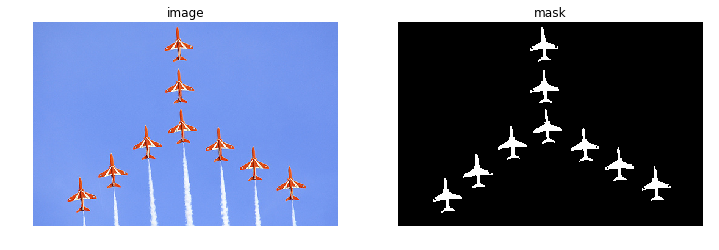

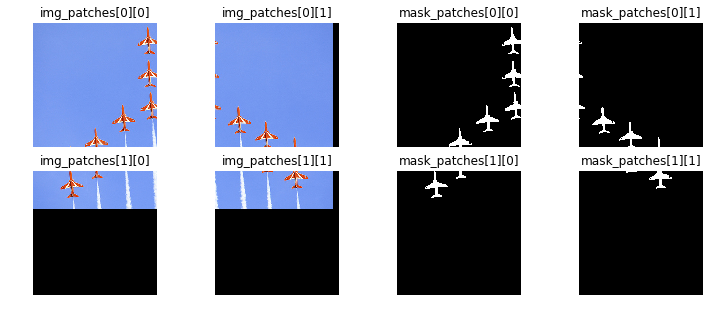

In [5]:
img_name = '2805945719_a77fcbd727'
img_patches_path = f'{ICOSEG_SUBSET_80_PATH}/val/val_img_patches'
mask_patches_path = f'{ICOSEG_SUBSET_80_PATH}/val/val_mask_patches'

img = skimage.io.imread(f'{ICOSEG_SUBSET_80_PATH}/images/{img_name}.jpg')
img_h, img_w = img.shape[:2]
print(f'real img_h, img_w: {img_h}, {img_w}')

# load_patches
img_patches = load_patches(img_name, img_patches_path)
print('img_patches')
print(img_patches.shape, img_patches.dtype,
      img_patches.min(), img_patches.max(), '\n')

mask_patches = load_patches(img_name, mask_patches_path)
print('mask_patches')
print(mask_patches.shape, mask_patches.dtype,
      mask_patches.min(), mask_patches.max(), '\n')

# merge_patches
img_from_patches = merge_patches(img_patches, img_h=img_h, img_w=img_w)
print('img_from_patches')
print(img_from_patches.shape, img_from_patches.dtype,
      img_from_patches.min(), img_from_patches.max())

mask_from_patches = merge_patches(mask_patches, img_h=img_h, img_w=img_w)
print('mask_from_patches')
print(mask_from_patches.shape, mask_from_patches.dtype,
      mask_from_patches.min(), mask_from_patches.max())

# grid_vis
grid_vis_for_crop_and_merge(img_from_patches, img_patches,
                            mask_from_patches, mask_patches)

## 3. Merge patches and save (for images from a dataset split)

In [6]:
def merge_patches_and_save(img_shapes, img_names, patches_path,
                           save_path, img_format):
    
    if not os.path.isdir(save_path):
        os.makedirs(save_path)
    
    for img_shape, img_name in zip(img_shapes, img_names):
        img_h, img_w = img_shape[:2]
        patches = load_patches(img_name, patches_path)
        img_from_patches = merge_patches(patches, img_h=img_h, img_w=img_w)
        
        filename = f'{save_path}/{img_name}.{img_format}'
        skimage.io.imsave(filename, img_from_patches)
        
def get_img_shapes(images):
    return [img.shape for img in images]

In [7]:
_, _, val, val_img_names, _, _ = load_icoseg_subset_80_with_img_names()
val_images, val_masks = val
val_img_shapes = get_img_shapes(val_images)

img_patches_path = f'{ICOSEG_SUBSET_80_PATH}/val/val_img_patches'
img_save_path = f'{ICOSEG_SUBSET_80_PATH}/val/val_img_from_patches'

mask_patches_path = f'{ICOSEG_SUBSET_80_PATH}/val/val_mask_patches'
mask_save_path = f'{ICOSEG_SUBSET_80_PATH}/val/val_mask_from_patches'

merge_patches_and_save(val_img_shapes, val_img_names, img_patches_path,
                       img_save_path, img_format='png')
merge_patches_and_save(val_img_shapes, val_img_names, mask_patches_path,
                       mask_save_path, img_format='png')

## 4. Merge patches and save all (for all dataset splits)

In [8]:
def merge_patches_and_save_all(dataset_with_img_names,
                               dataset_path,
                               img_format='png'):
    
    # dataset splits
    train, train_img_names, val, val_img_names, test, test_img_names = dataset_with_img_names
    train_images, train_masks = train
    val_images, val_masks = val
    test_images, test_masks = test
    
    d_splits = [(train_images, train_img_names, 'train_img'),
                (train_masks, train_img_names, 'train_mask'),
                (val_images, val_img_names, 'val_img'),
                (val_masks, val_img_names, 'val_mask'),
                (test_images, test_img_names, 'test_img'),
                (test_masks, test_img_names, 'test_mask')]
    
    for images, img_names, split_name in d_splits:
        patches_path = f'{dataset_path}/{split_name.split("_")[0]}/{split_name}_patches'
        save_path = f'{dataset_path}/{split_name.split("_")[0]}/{split_name}_from_patches'
        img_shapes = get_img_shapes(images)
        
        merge_patches_and_save(img_shapes, img_names,
                               patches_path=patches_path,
                               save_path=save_path,
                               img_format=img_format)

In [9]:
%%time
merge_patches_and_save_all(load_icoseg_subset_80_with_img_names(),
                           dataset_path=ICOSEG_SUBSET_80_PATH,
                           img_format='png')

CPU times: user 7.53 s, sys: 96 ms, total: 7.62 s
Wall time: 7.84 s
